In [1]:
import os 
import timm
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightly.data.dataset import LightlyDataset

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from multissl.models import MSRGBInstanceModule
from multissl.plotting.rgb_batch import rgb_visualize_batch
from multissl.data.instance_segmentation_dataset import COCOInstanceSegmentationDataset, get_instance_transforms,instance_segmentation_collate_fn

# Segmentation Head Loading

In [3]:

args = {"checkpoint_path":"../checkpoints_convnext_tiny/last.ckpt",
    "num_classes": 2,
    "class_names": ["Background", "Solarpanel"],
    "freeze_backbone": True,
    "batch_size": 4,
    "img_size": 224,

       }
# pretrained tiny has hierarchical fusion: at every layer MS +RGB is fused with attention

pl_model =  MSRGBInstanceModule(
        num_classes=args["num_classes"],  # Binary segmentation (background, foreground)
        rgb_in_channels=3,
        ms_in_channels=5,  # Adjust based on your MS data
        model_size='tiny',  # Can be 'tiny', 'small', 'base', 'large'
        fusion_strategy='hierarchical',  # 'early', 'late', 'hierarchical', 'progressive'
        fusion_type='attention',  # 'concat', 'add', 'attention'
        lr=1e-3,
        weight_decay=1e-4,
        pretrained_backbone=args["checkpoint_path"],  # Path to pretrained weights if available
        freeze_backbone = args["freeze_backbone"]
    )

Loading checkpoint from ../checkpoints_convnext_tiny/last.ckpt
Unexpected keys: ['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.layers.

In [4]:
image_path = "../dataset/solarcoco/imgs"
mask_path = "../dataset/solarcoco/annotations/frame_000003.json"
instance_path = "../dataset/solarcoco/instance"


# Create dataset
dataset = COCOInstanceSegmentationDataset(
   coco_json_path = mask_path,
    img_dir = image_path,
    instance_dir = instance_path,
    transform=get_instance_transforms(img_size=args["img_size"], augment=True)

)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:

import torch
from torch.utils.data import Sampler
import numpy as np


class RepeatingBatchSampler(Sampler):
    """
    Sampler that repeats dataset indices to ensure each batch contains batch_size items.
    Useful when working with small datasets or when you want to apply heavy augmentation
    to a small set of samples.
    """
    def __init__(self, dataset_size, batch_size, shuffle=True):
        """
        Args:
            dataset_size: Number of samples in the original dataset
            batch_size: Desired batch size 
            shuffle: Whether to shuffle the data or access sequentially
        """
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Number of copies needed for each dataset item
        self.copies_per_item = max(1, batch_size // dataset_size)
        
        # Extra samples needed beyond perfect division
        self.extra_samples = batch_size - (dataset_size * self.copies_per_item)
        if self.extra_samples < 0:
            self.extra_samples = 0
        
        # Total number of indices we'll generate
        self.total_samples = dataset_size * self.copies_per_item + self.extra_samples
        
    def __iter__(self):
        # Create base indices
        if self.shuffle:
            # For each "epoch", we shuffle the dataset order
            base_indices = torch.randperm(self.dataset_size).tolist()
        else:
            base_indices = list(range(self.dataset_size))
        
        # Repeat each index the required number of times
        repeated_indices = []
        for idx in base_indices:
            repeated_indices.extend([idx] * self.copies_per_item)
        
        # Add extra samples if needed to exactly reach batch_size
        if self.extra_samples > 0:
            extra_indices = base_indices[:self.extra_samples]
            repeated_indices.extend(extra_indices)
        
        # Shuffle the final indices to mix different samples
        if self.shuffle:
            np.random.shuffle(repeated_indices)
        
        return iter(repeated_indices)
    
    def __len__(self):
        return self.total_samples

In [6]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import ListedColormap
import random

def plot_batch_item(batch_item, figsize=(15, 5), show_masks=True, show_boxes=True, 
                   mask_alpha=0.7, box_linewidth=2):
    """
    Plot a single item from a batch containing:
    - rgb: RGB image tensor (C, H, W)
    - boxes: List of bounding boxes in format [confidence, cx, cy, w, h] (normalized)
    - instance_masks: List of instance segmentation masks
    - mask: Semantic segmentation mask
    
    Args:
        batch_item: Dictionary with keys 'rgb', 'boxes', 'instance_masks', 'mask'
        figsize: Figure size tuple
        show_masks: Whether to show instance masks
        show_boxes: Whether to show bounding boxes
        mask_alpha: Transparency for mask overlay
        box_linewidth: Line width for bounding boxes
    """
    
    # Extract data
    rgb_tensor = batch_item.get('rgb')
    boxes = batch_item.get('boxes')  # Use empty list if no boxes
    instance_masks = batch_item.get('instance_masks')  # Use empty list if no masks
    semantic_mask = batch_item.get('mask')
    
    # Convert RGB tensor to numpy (H, W, 3)
    if isinstance(rgb_tensor, torch.Tensor):
        if len(rgb_tensor.shape) == 3:  # (C, H, W)
            rgb_img = rgb_tensor.permute(1, 2, 0).numpy()
        elif len(rgb_tensor.shape) == 4:  # (B, C, H, W) - take first item in batch
            rgb_img = rgb_tensor[0].permute(1, 2, 0).numpy()
        else:
            raise ValueError(f"Unexpected RGB tensor shape: {rgb_tensor.shape}")
    else:
        rgb_img = rgb_tensor
    
    # Ensure RGB values are in [0, 1] range
    rgb_img = np.clip(rgb_img, 0, 1)
    
    # Get image dimensions
    height, width = rgb_img.shape[:2]
    
    # Create subplots - adjust number based on available data
    n_plots = 1
    if semantic_mask is not None:
        n_plots += 1
    if show_masks and instance_masks:
        n_plots += 1
        
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot 1: Original RGB image with bounding boxes
    ax_idx = 0
    axes[ax_idx].imshow(rgb_img)
    axes[ax_idx].set_title('RGB Image with Bounding Boxes')
    axes[ax_idx].axis('off')
    
    if show_boxes and boxes:
        # Generate colors for different instances
        colors = plt.cm.tab20(np.linspace(0, 1, len(boxes)))
        
        for i, box in enumerate(boxes):
            if isinstance(box, torch.Tensor):
                box = box.numpy()
            
            # Convert from (confidence, cx, cy, w, h) to pixel coordinates
            confidence = box[0]
            cx, cy, w, h = box[1:]
            
            # Convert normalized coordinates to pixel coordinates
            x_center = cx * width
            y_center = cy * height
            box_width = w * width
            box_height = h * height
            
            # Convert center coordinates to top-left coordinates
            x_left = x_center - box_width / 2
            y_top = y_center - box_height / 2
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x_left, y_top), box_width, box_height,
                linewidth=box_linewidth, edgecolor=colors[i], 
                facecolor='none', alpha=0.8
            )
            axes[ax_idx].add_patch(rect)
            
            # Add label
            class_id = i  # Use index if class not provided
            axes[ax_idx].text(x_left, y_top - 5, f'Box {i} ({confidence:.2f})',
                        color=colors[i], fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Plot 2: Semantic segmentation mask (if available)
    if semantic_mask is not None:
        ax_idx += 1
        if isinstance(semantic_mask, torch.Tensor):
            semantic_mask = semantic_mask.numpy()
        
        # Create a colormap for the semantic mask
        unique_values = np.unique(semantic_mask)
        n_classes = len(unique_values)
        cmap = plt.cm.get_cmap('viridis', max(n_classes, 10))
        
        # Display the mask
        im = axes[ax_idx].imshow(semantic_mask, cmap=cmap)
        axes[ax_idx].set_title('Semantic Segmentation Mask')
        axes[ax_idx].axis('off')
        
        # Add a color bar
        if n_classes > 1:  # Only add colorbar if we have multiple classes
            plt.colorbar(im, ax=axes[ax_idx], ticks=unique_values)
    
    # Plot 3: Instance masks overlay (if requested and available)
    if show_masks and instance_masks and ax_idx + 1 < len(axes):
        ax_idx += 1
        # Create overlay image
        overlay_img = rgb_img.copy()
        
        # Generate distinct colors for different instances
        colors = plt.cm.tab20(np.linspace(0, 1, len(instance_masks)))
        
        for i, mask in enumerate(instance_masks):
            if isinstance(mask, torch.Tensor):
                mask = mask.numpy()
                
            # Create a binary mask (ensure boolean type)
            binary_mask = mask > 0.5  # Convert to boolean mask
            
            # Create colored mask
            color_mask = np.zeros_like(rgb_img)
            for c in range(3):  # Apply color to each channel
                color_mask[:, :, c] = np.where(binary_mask, colors[i][c], 0)
            
            # Blend with original image
            mask_area = binary_mask[:, :, np.newaxis] if binary_mask.ndim == 2 else binary_mask
            overlay_img = overlay_img * (1 - mask_area * mask_alpha) + color_mask * mask_area * mask_alpha
        
        axes[ax_idx].imshow(np.clip(overlay_img, 0, 1))
        axes[ax_idx].set_title('RGB Image with Instance Masks')
        axes[ax_idx].axis('off')
    
    plt.tight_layout()
    return fig, axes

def process_batch_for_visualization(batch):
    """
    Process batch data to make it suitable for visualization.
    
    Args:
        batch: Raw batch data as provided
    
    Returns:
        List of batch items ready for visualization
    """
   
    rgb = batch.get("rgb")
    batch_size = rgb.shape[0] 
    # If batch contains img_ids, use that to create separate batch items
    batch_items = []
    for img_id in range(batch_size):
        
        # Create a new batch item for this image ID
        batch_item = {
            'rgb': batch['rgb'][img_id],  # Assuming one RGB per image ID
            'mask': batch['mask'][img_id] if 'mask' in batch else None,
            'boxes': batch['boxes'][img_id] if len(batch["boxes"][img_id])>0 else None,
            'instance_masks': batch['instance_masks'][img_id] if len(batch["instance_masks"][img_id])>0 else None,
        }
        batch_items.append(batch_item)
    
    return batch_items
    

def plot_batch(batch, max_items=4, **kwargs):
    """
    Plot multiple items from a batch.
    
    Args:
        batch: Batch data (can be a dictionary for a single item,
               or a structure with multiple items)
        max_items: Maximum number of items to plot
        **kwargs: Additional arguments passed to plot_batch_item
    """
    # Process the batch to get a list of items
    batch_items = process_batch_for_visualization(batch)
    
    # Limit the number of items to plot
    n_items = min(len(batch_items), max_items)
    
    # Plot each item
    for i in range(n_items):
        print(f"\nPlotting batch item {i}:")
        fig, axes = plot_batch_item(batch_items[i], **kwargs)
        plt.show()

In [37]:
sampler = RepeatingBatchSampler(dataset_size=len(dataset),batch_size=args["batch_size"],
    shuffle=True
)
collate_fn = instance_segmentation_collate_fn
# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=args["batch_size"], 
    num_workers=0,
    # Use 0 for single image to avoid overhead,
    sampler = sampler,
    collate_fn = collate_fn,
    drop_last= True


)


Plotting batch item 0:


C:\Users\judoj\AppData\Local\Temp\ipykernel_23116\2271471554.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(n_classes, 10))


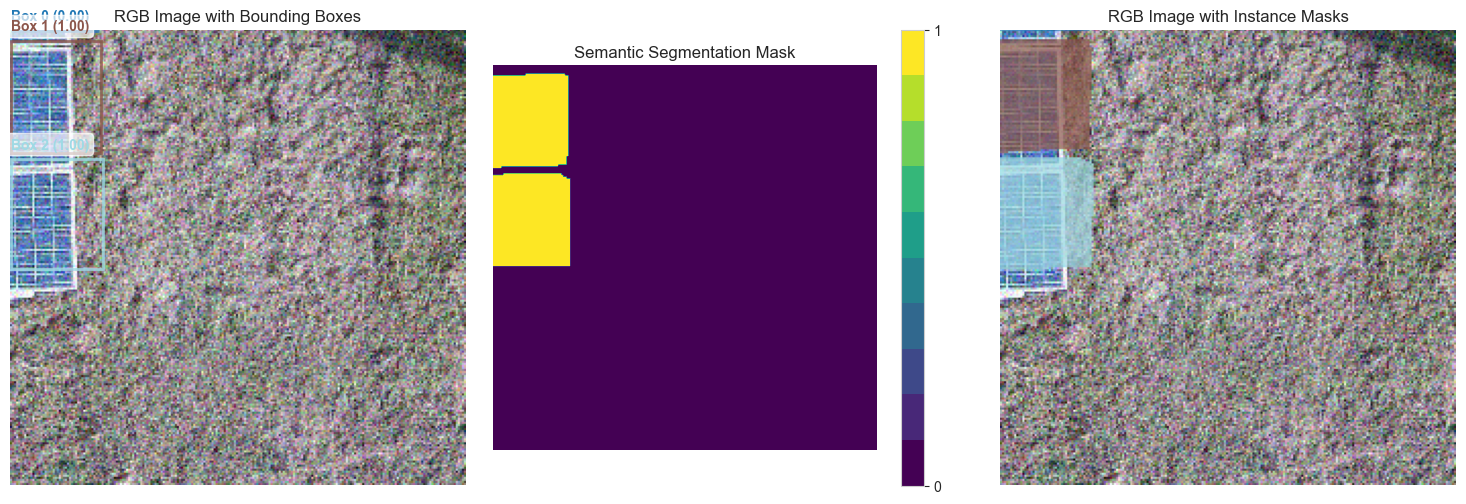

In [38]:
batch= next(iter(dataloader))
plot_batch(batch, max_items=1)

In [39]:
# Create progress bar callback
from pytorch_lightning.callbacks import RichProgressBar
class LossProgressBar(RichProgressBar):
    def __init__(self):
        super().__init__()
        self.losses = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        loss = float(trainer.callback_metrics.get('train/total_loss_epoch', 0))
        self.losses.append(loss)
        
progress_bar = LossProgressBar()
import torch
pl_model.train()
# Create model checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='train/total_loss_epoch',
    filename='pasiphae-upernet-{epoch:02d}-{train/total_loss_epoch:.4f}',
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='train/total_loss_epoch',
    patience=50,
    mode='min'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    callbacks=[progress_bar, checkpoint_callback, early_stop_callback],
    logger=True,
    log_every_n_steps=1,
    accelerator = "cuda"
)

# Train model
print("Starting training...")
trainer.fit(pl_model, dataloader)

print("Training complete!")




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                          ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ MSRGBConvNeXtFeatureExtractor │ 85.3 M │ train │
│ 1 │ fpn       │ FeaturePyramidNetwork         │  2.7 M │ train │
│ 2 │ rpn       │ BatchedRegionProposalNetwork  │  593 K │ train │
│ 3 │ roi_heads │ ImprovedRoIHeads              │ 19.2 M │ train │
└───┴───────────┴───────────────────────────────┴────────┴───────┘

Trainable params: 22.6 M                                                                                           
Non-trainable params: 85.3 M                                                                                       
Total params: 107 M                                                                                                
Total estimated model params size (MB): 431                                                                        
Modules in train mode: 524                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.


Training complete!


In [32]:
# Apply to dataset:
# Create train/val/test datasets
rgb_transform = transforms.Compose([
    transforms.Resize((448,448 ), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


solar_folder = "../dataset/pvhawk" 

non_labeled = LightlyDataset(input_dir = "../dataset/pvhawk",transform=rgb_transform)
non_labeled = torch.utils.data.DataLoader(non_labeled)

In [33]:
batch = next(iter(non_labeled))


In [34]:

# Prepare your batch of images (no labels needed)
data = {
    'rgb': batch[0],  # Shape (B, 3, H, W)
    'ms' : None
}

# Get predictions
results = pl_model.predict_masks_and_boxes(
    rgb=data['rgb'], 
    ms=data['ms'],
    confidence_threshold=0.7  # Adjust as needed
)



Feature map: layer1, Shape: torch.Size([1, 96, 112, 112])


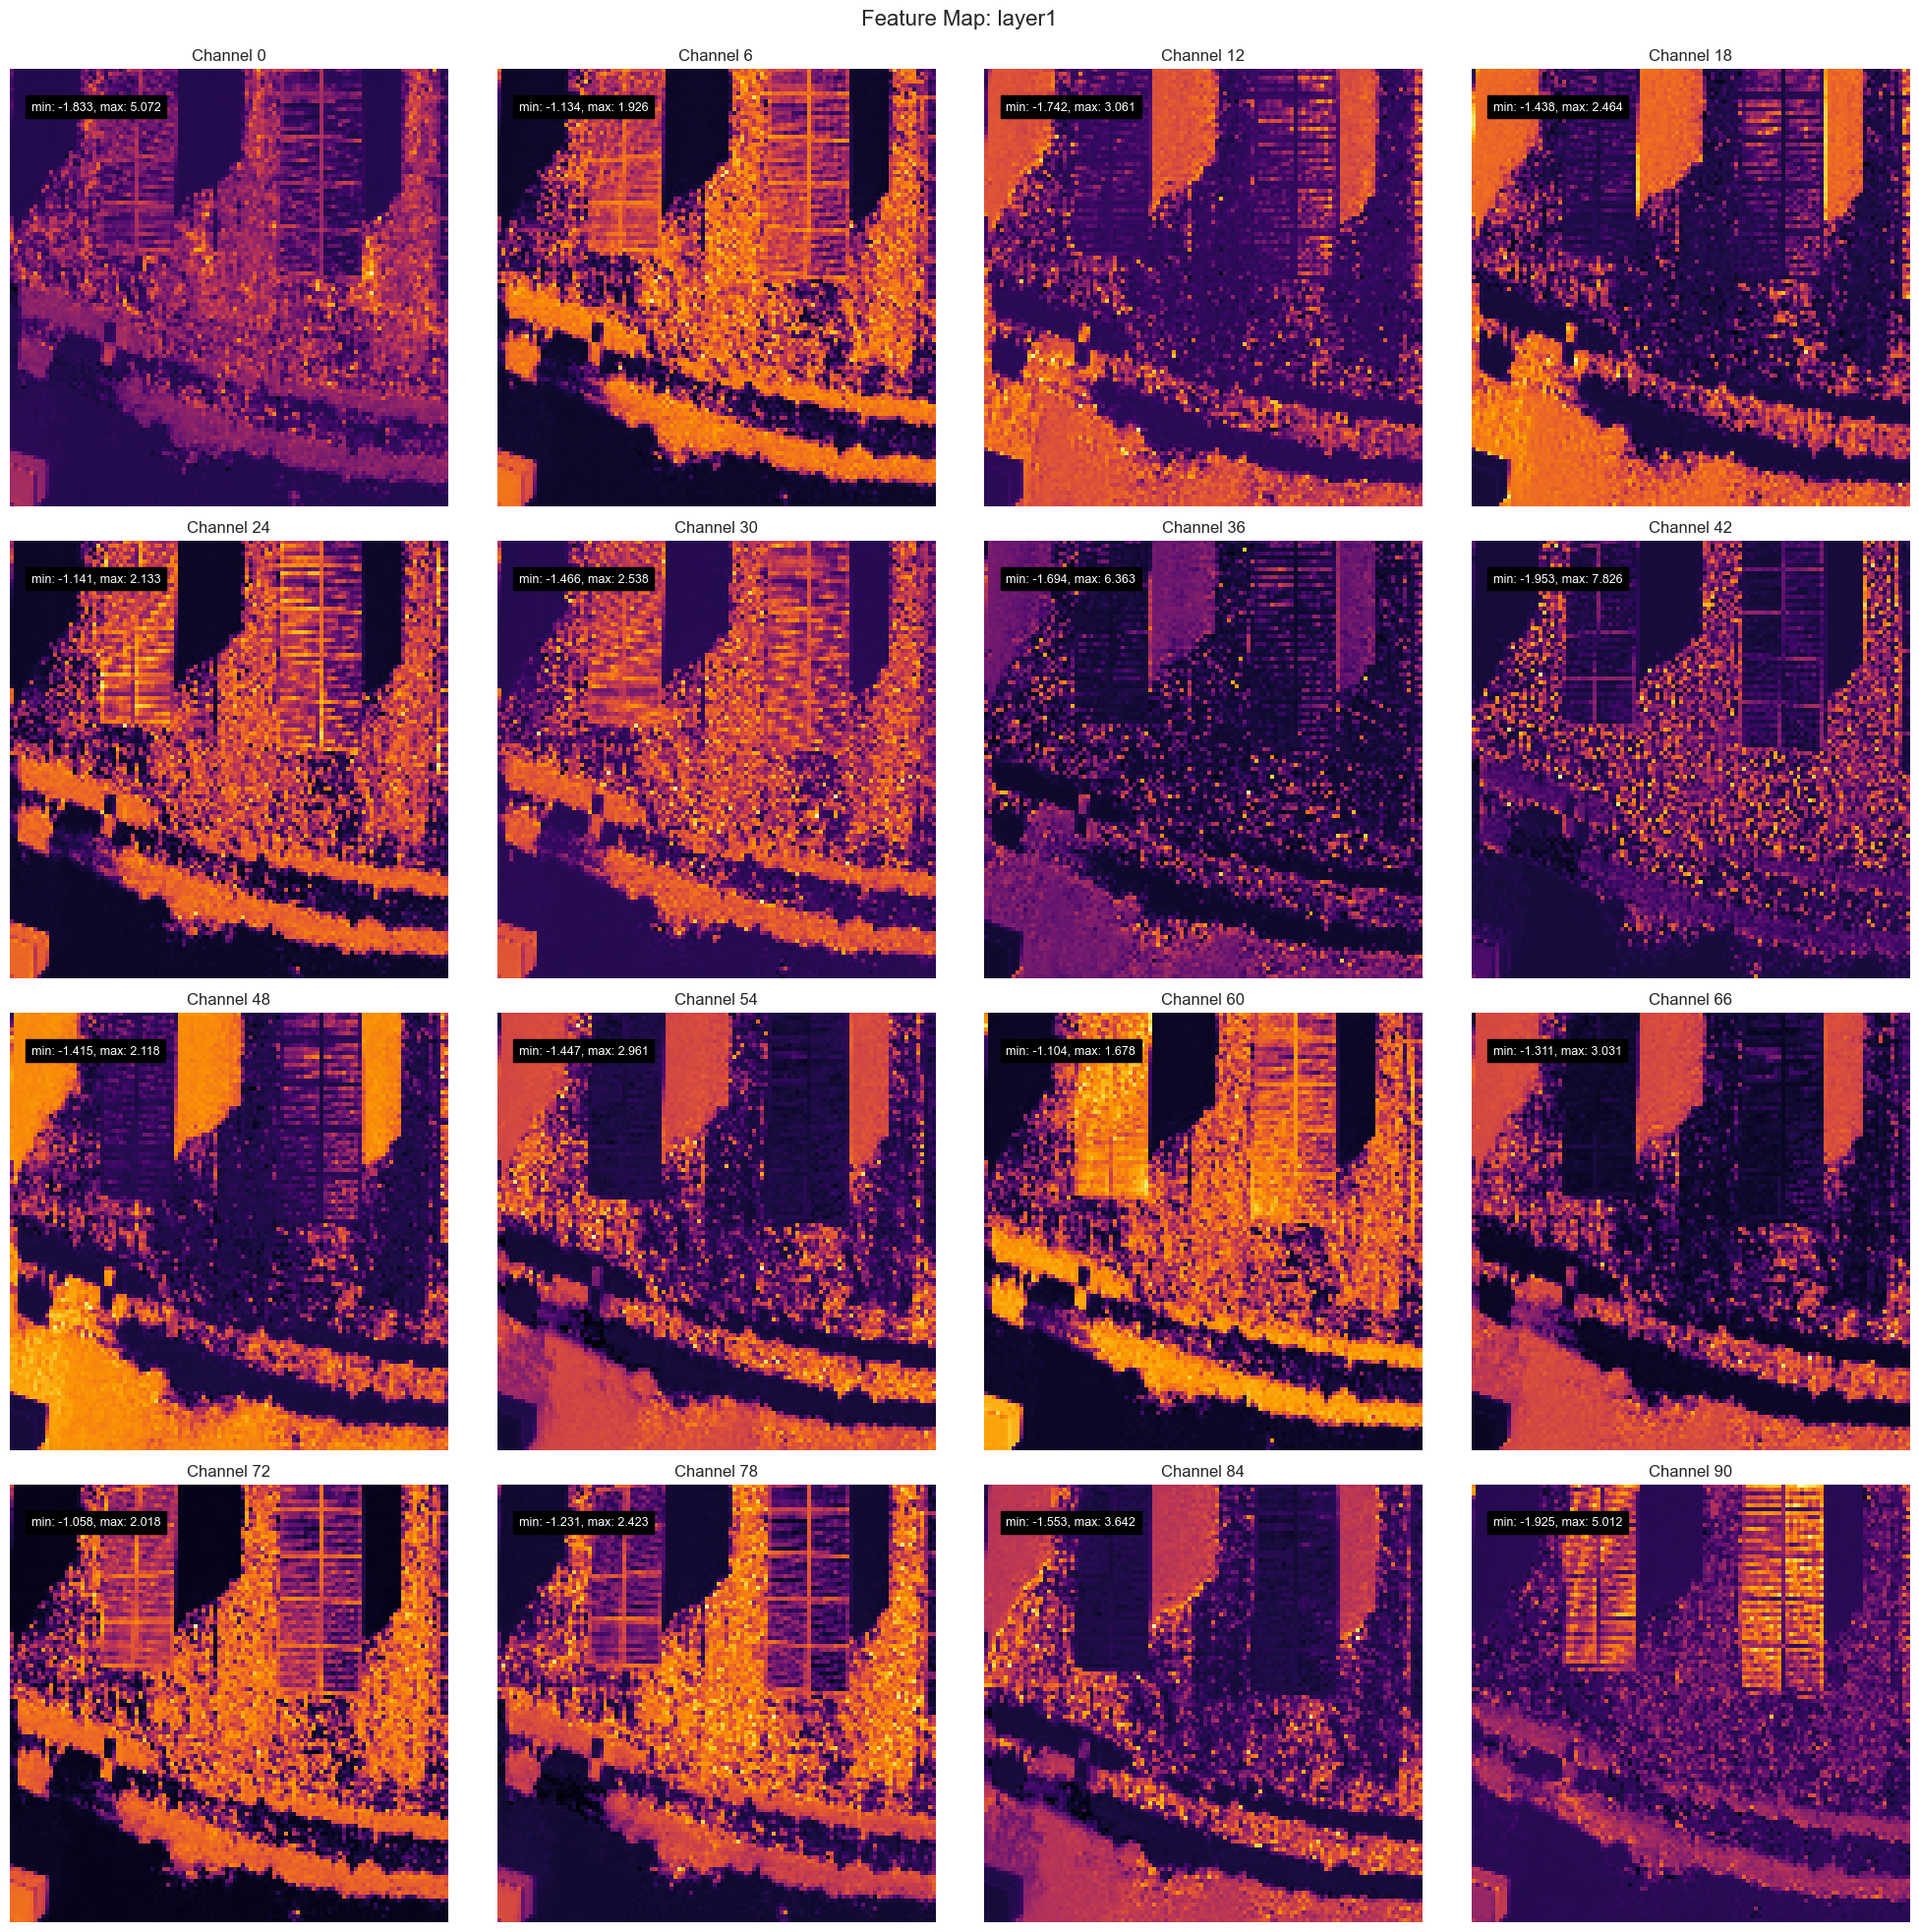


Feature map: layer2, Shape: torch.Size([1, 192, 56, 56])


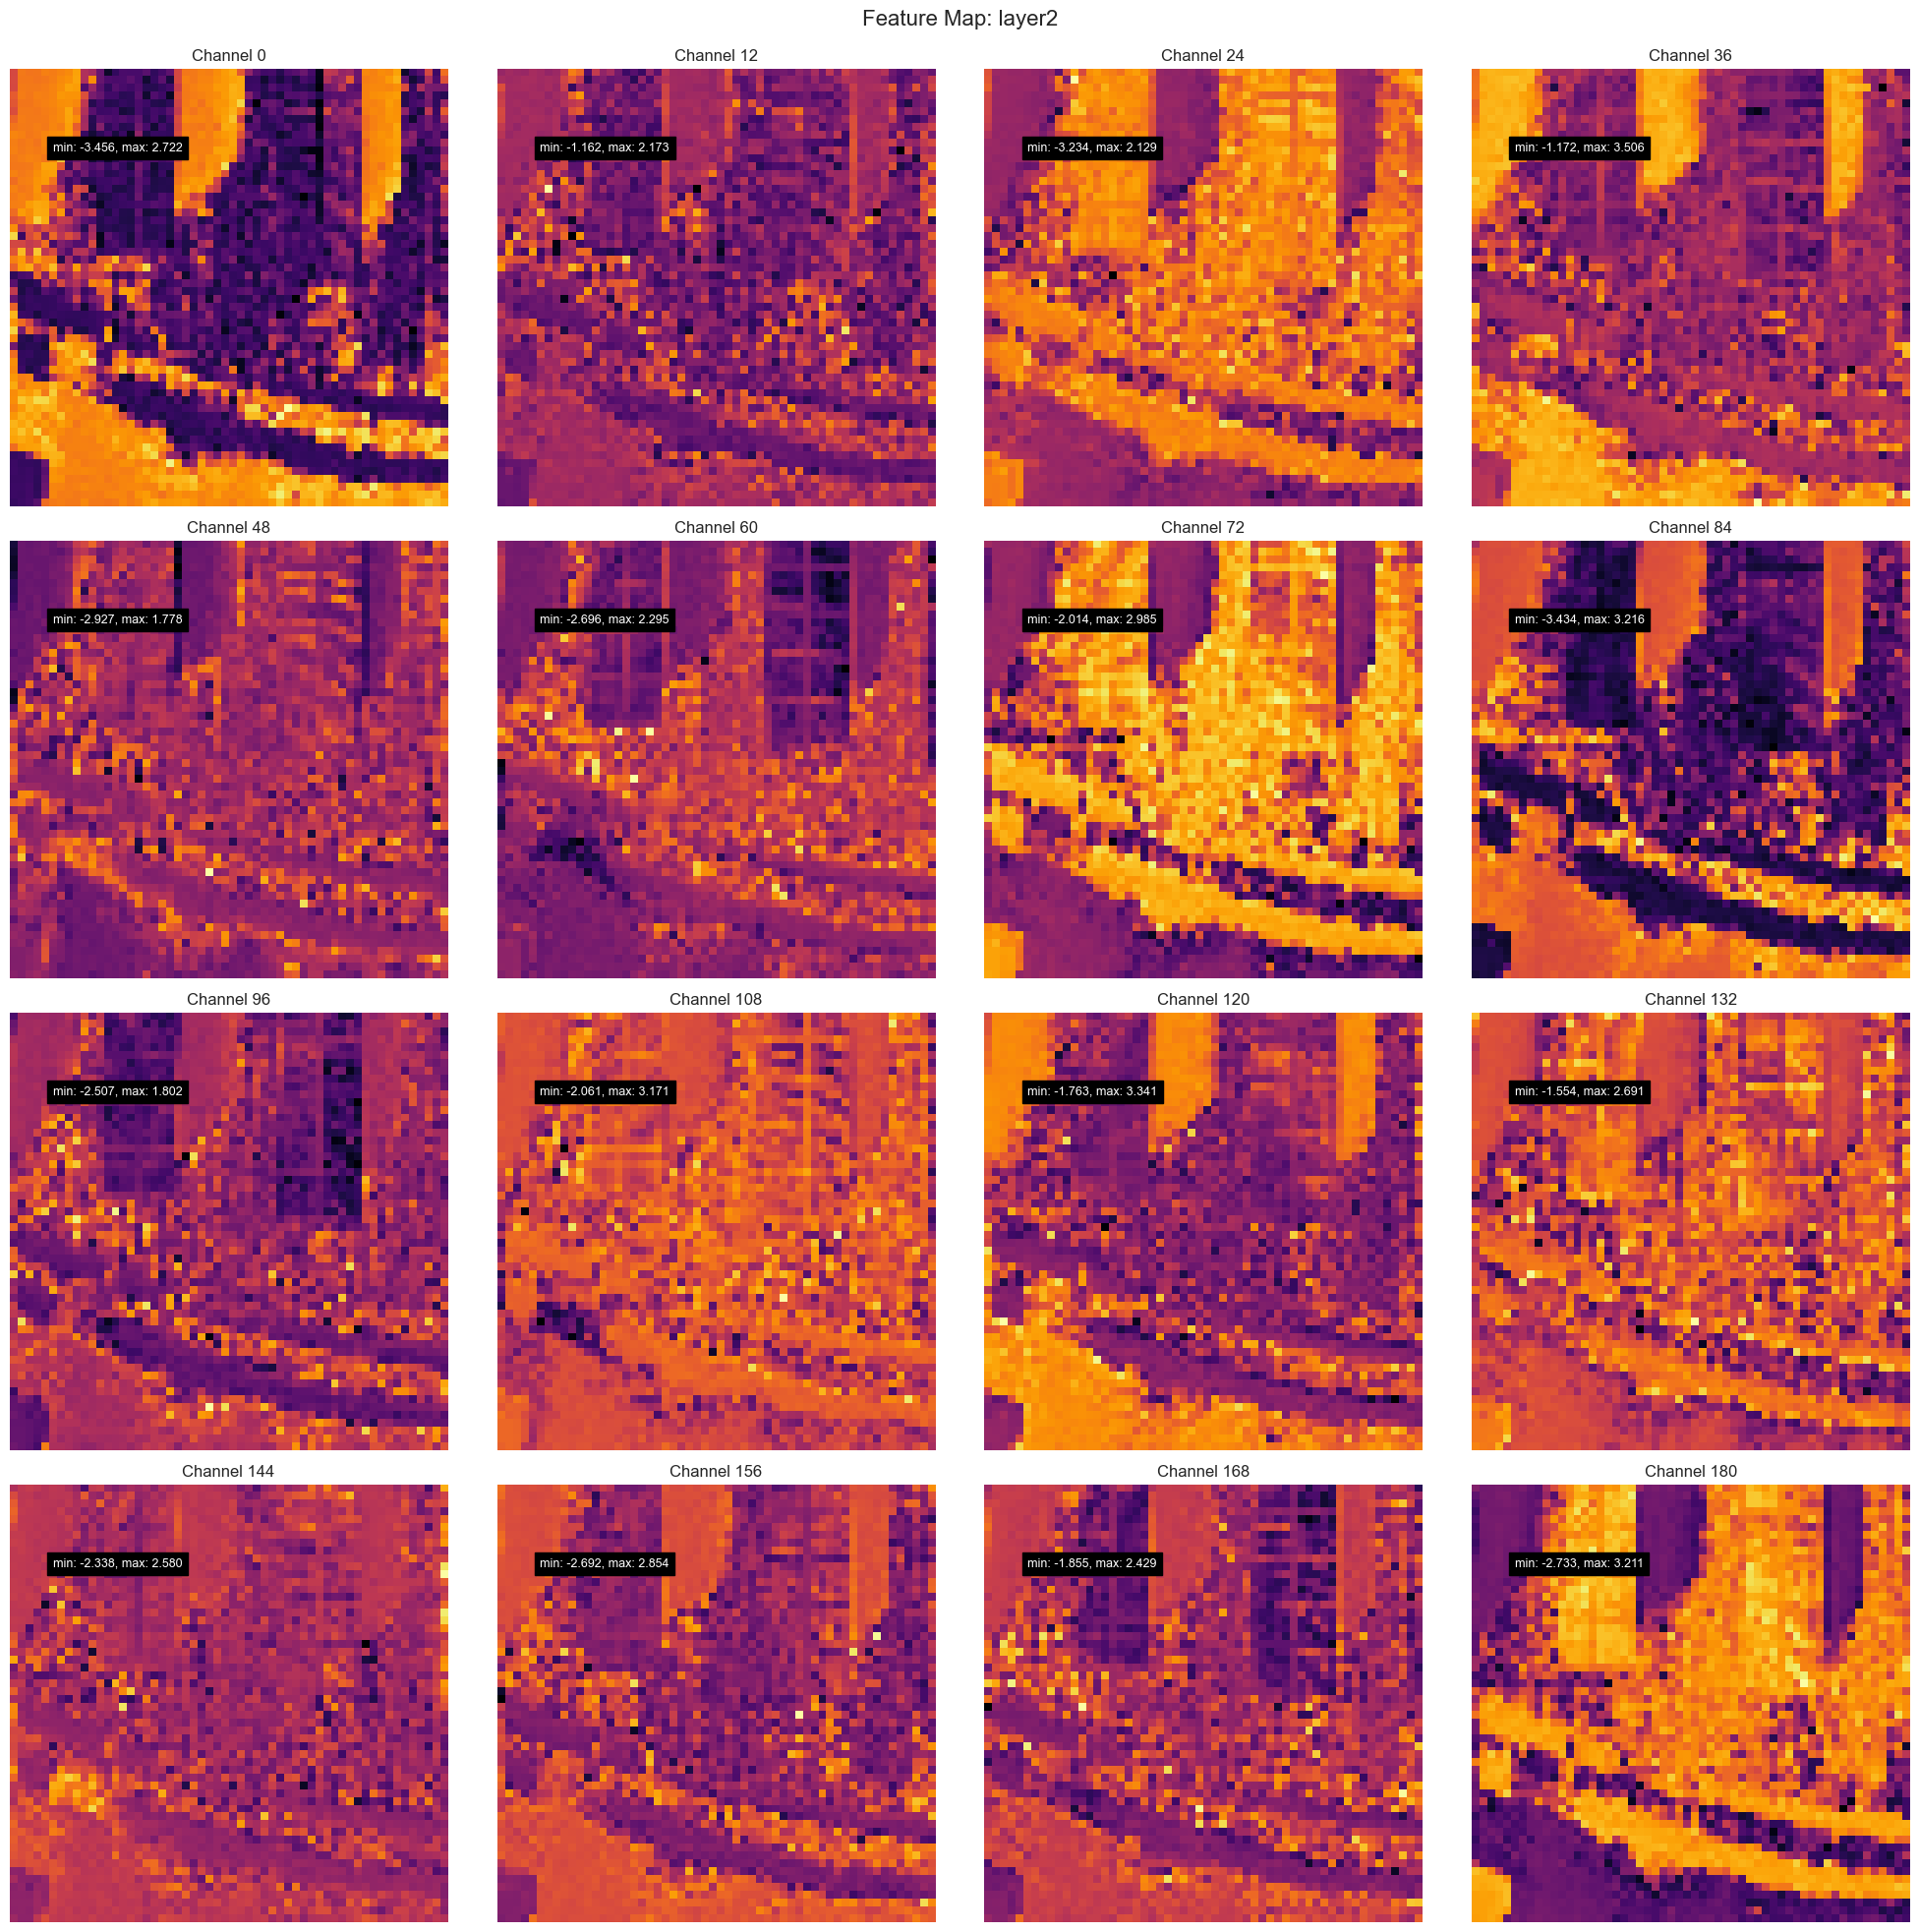


Feature map: layer3, Shape: torch.Size([1, 384, 28, 28])


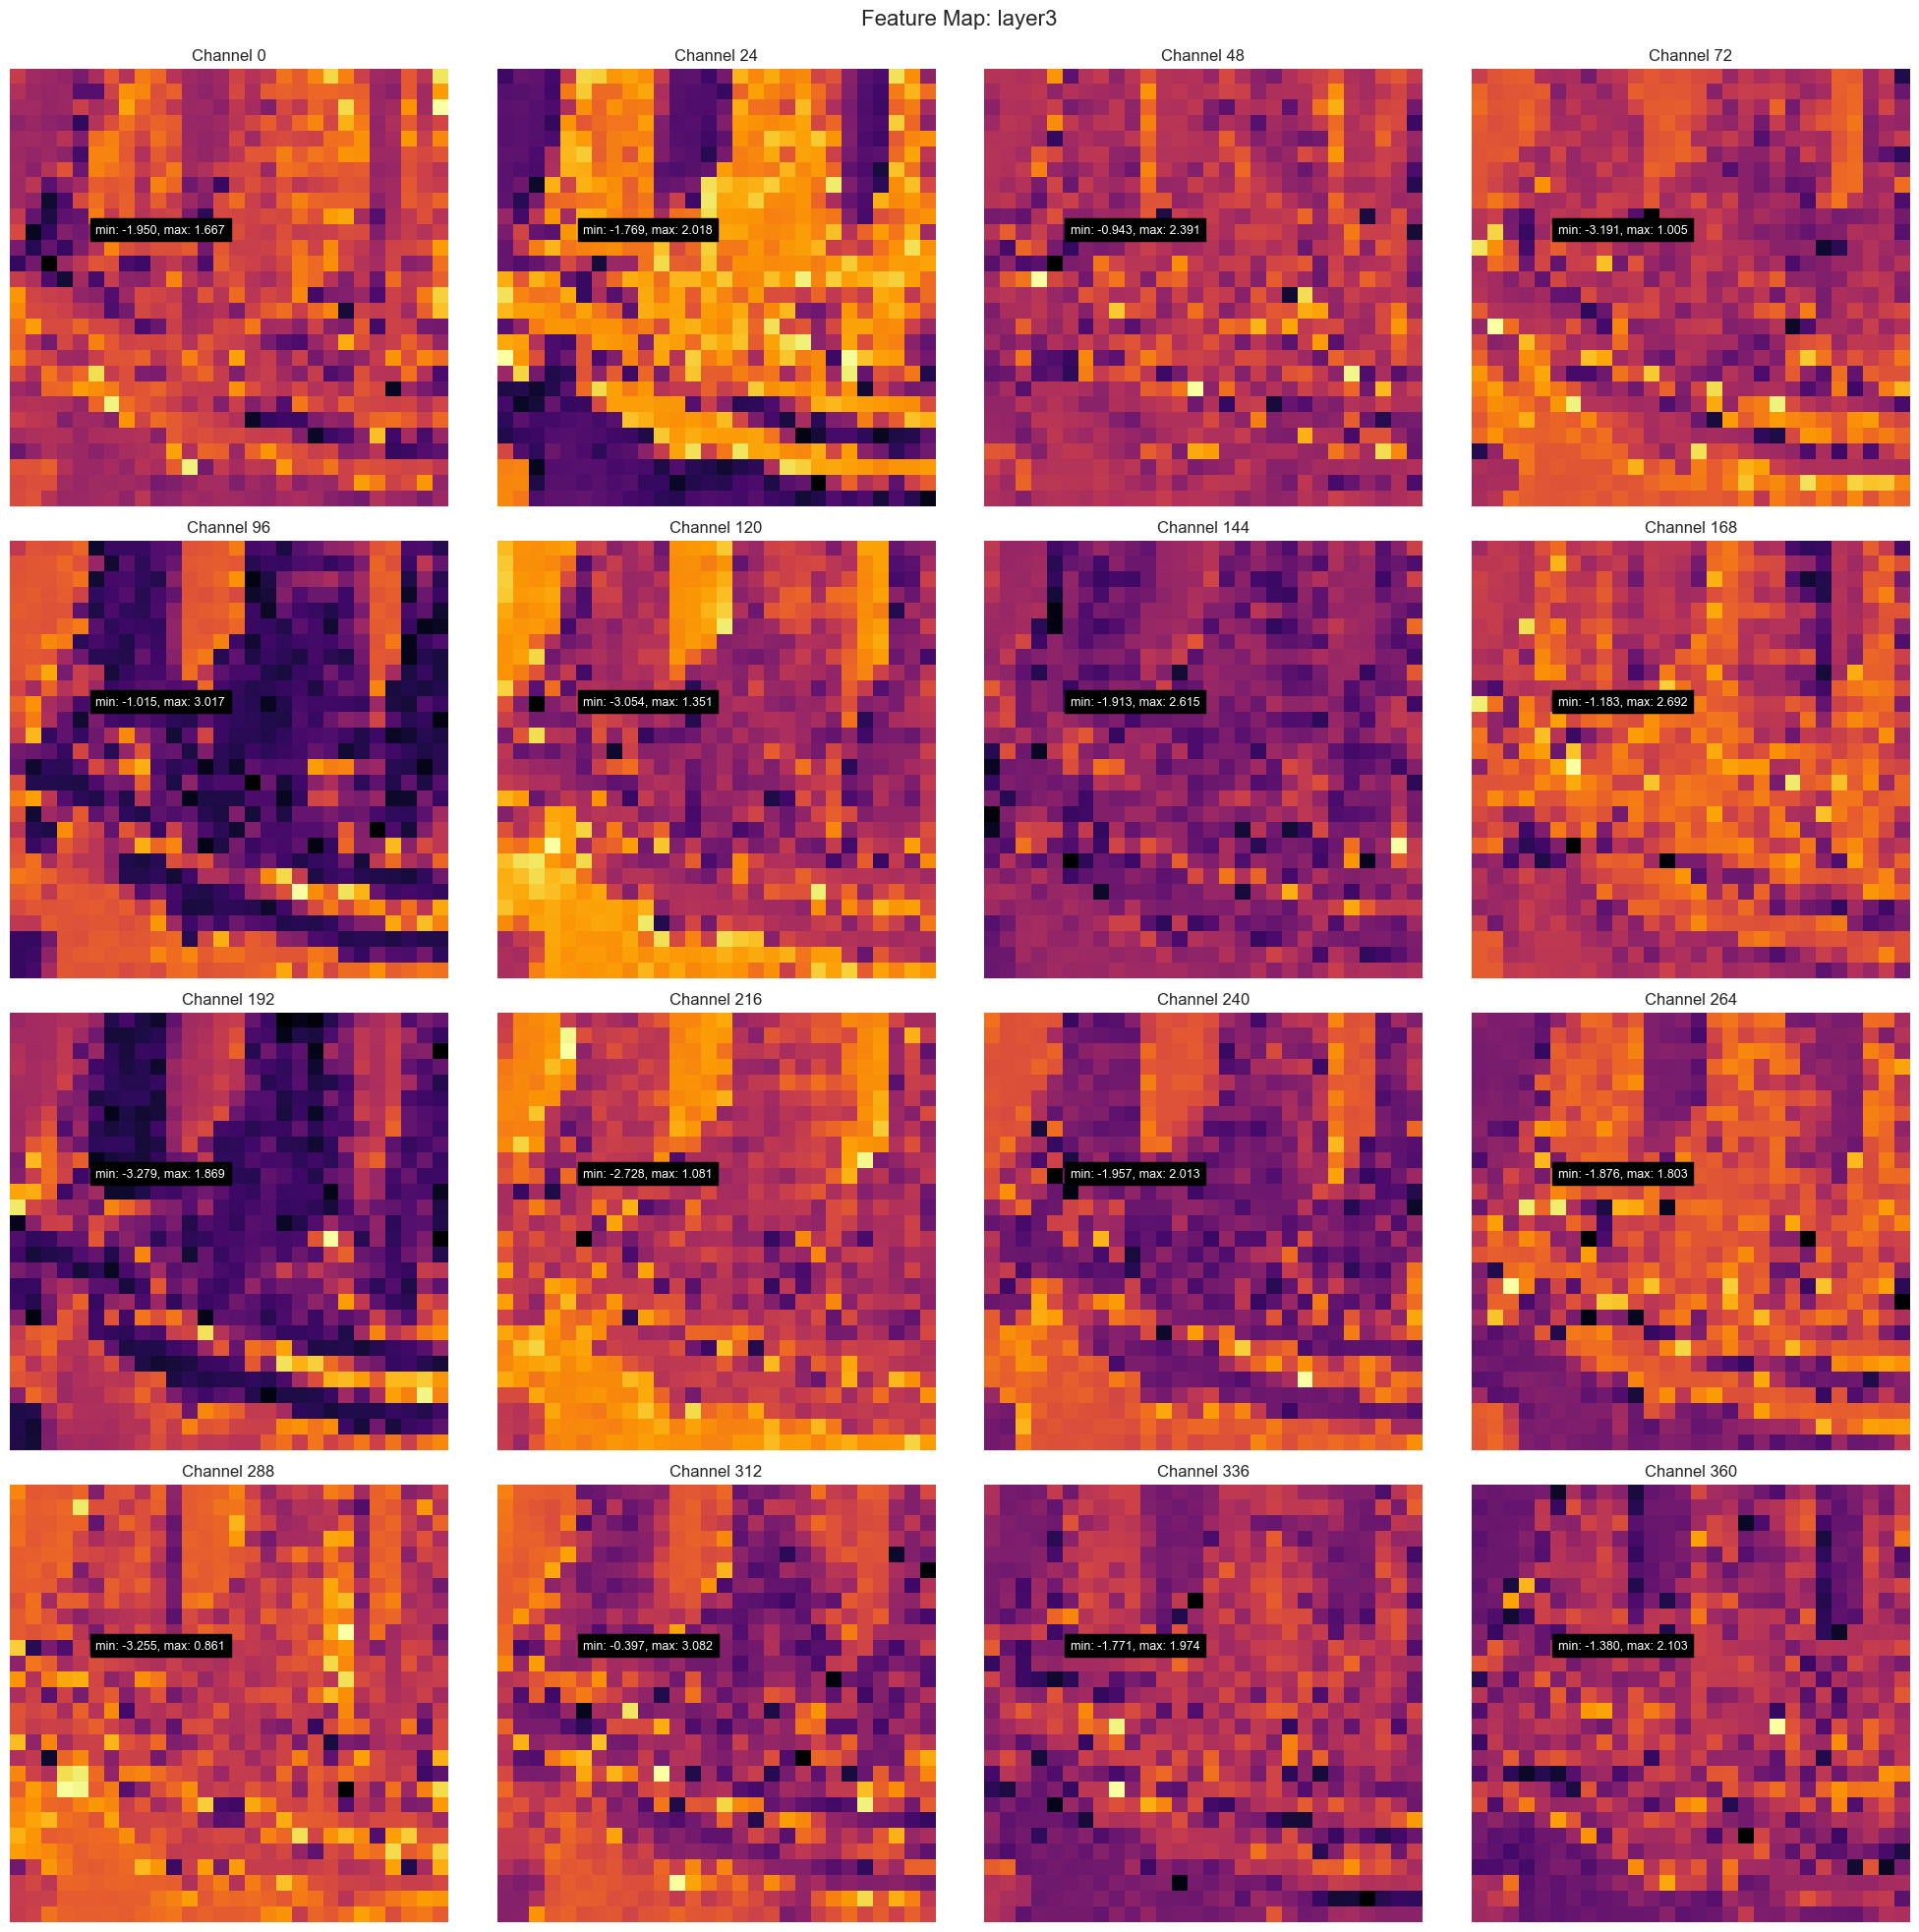


Feature map: layer4, Shape: torch.Size([1, 768, 14, 14])


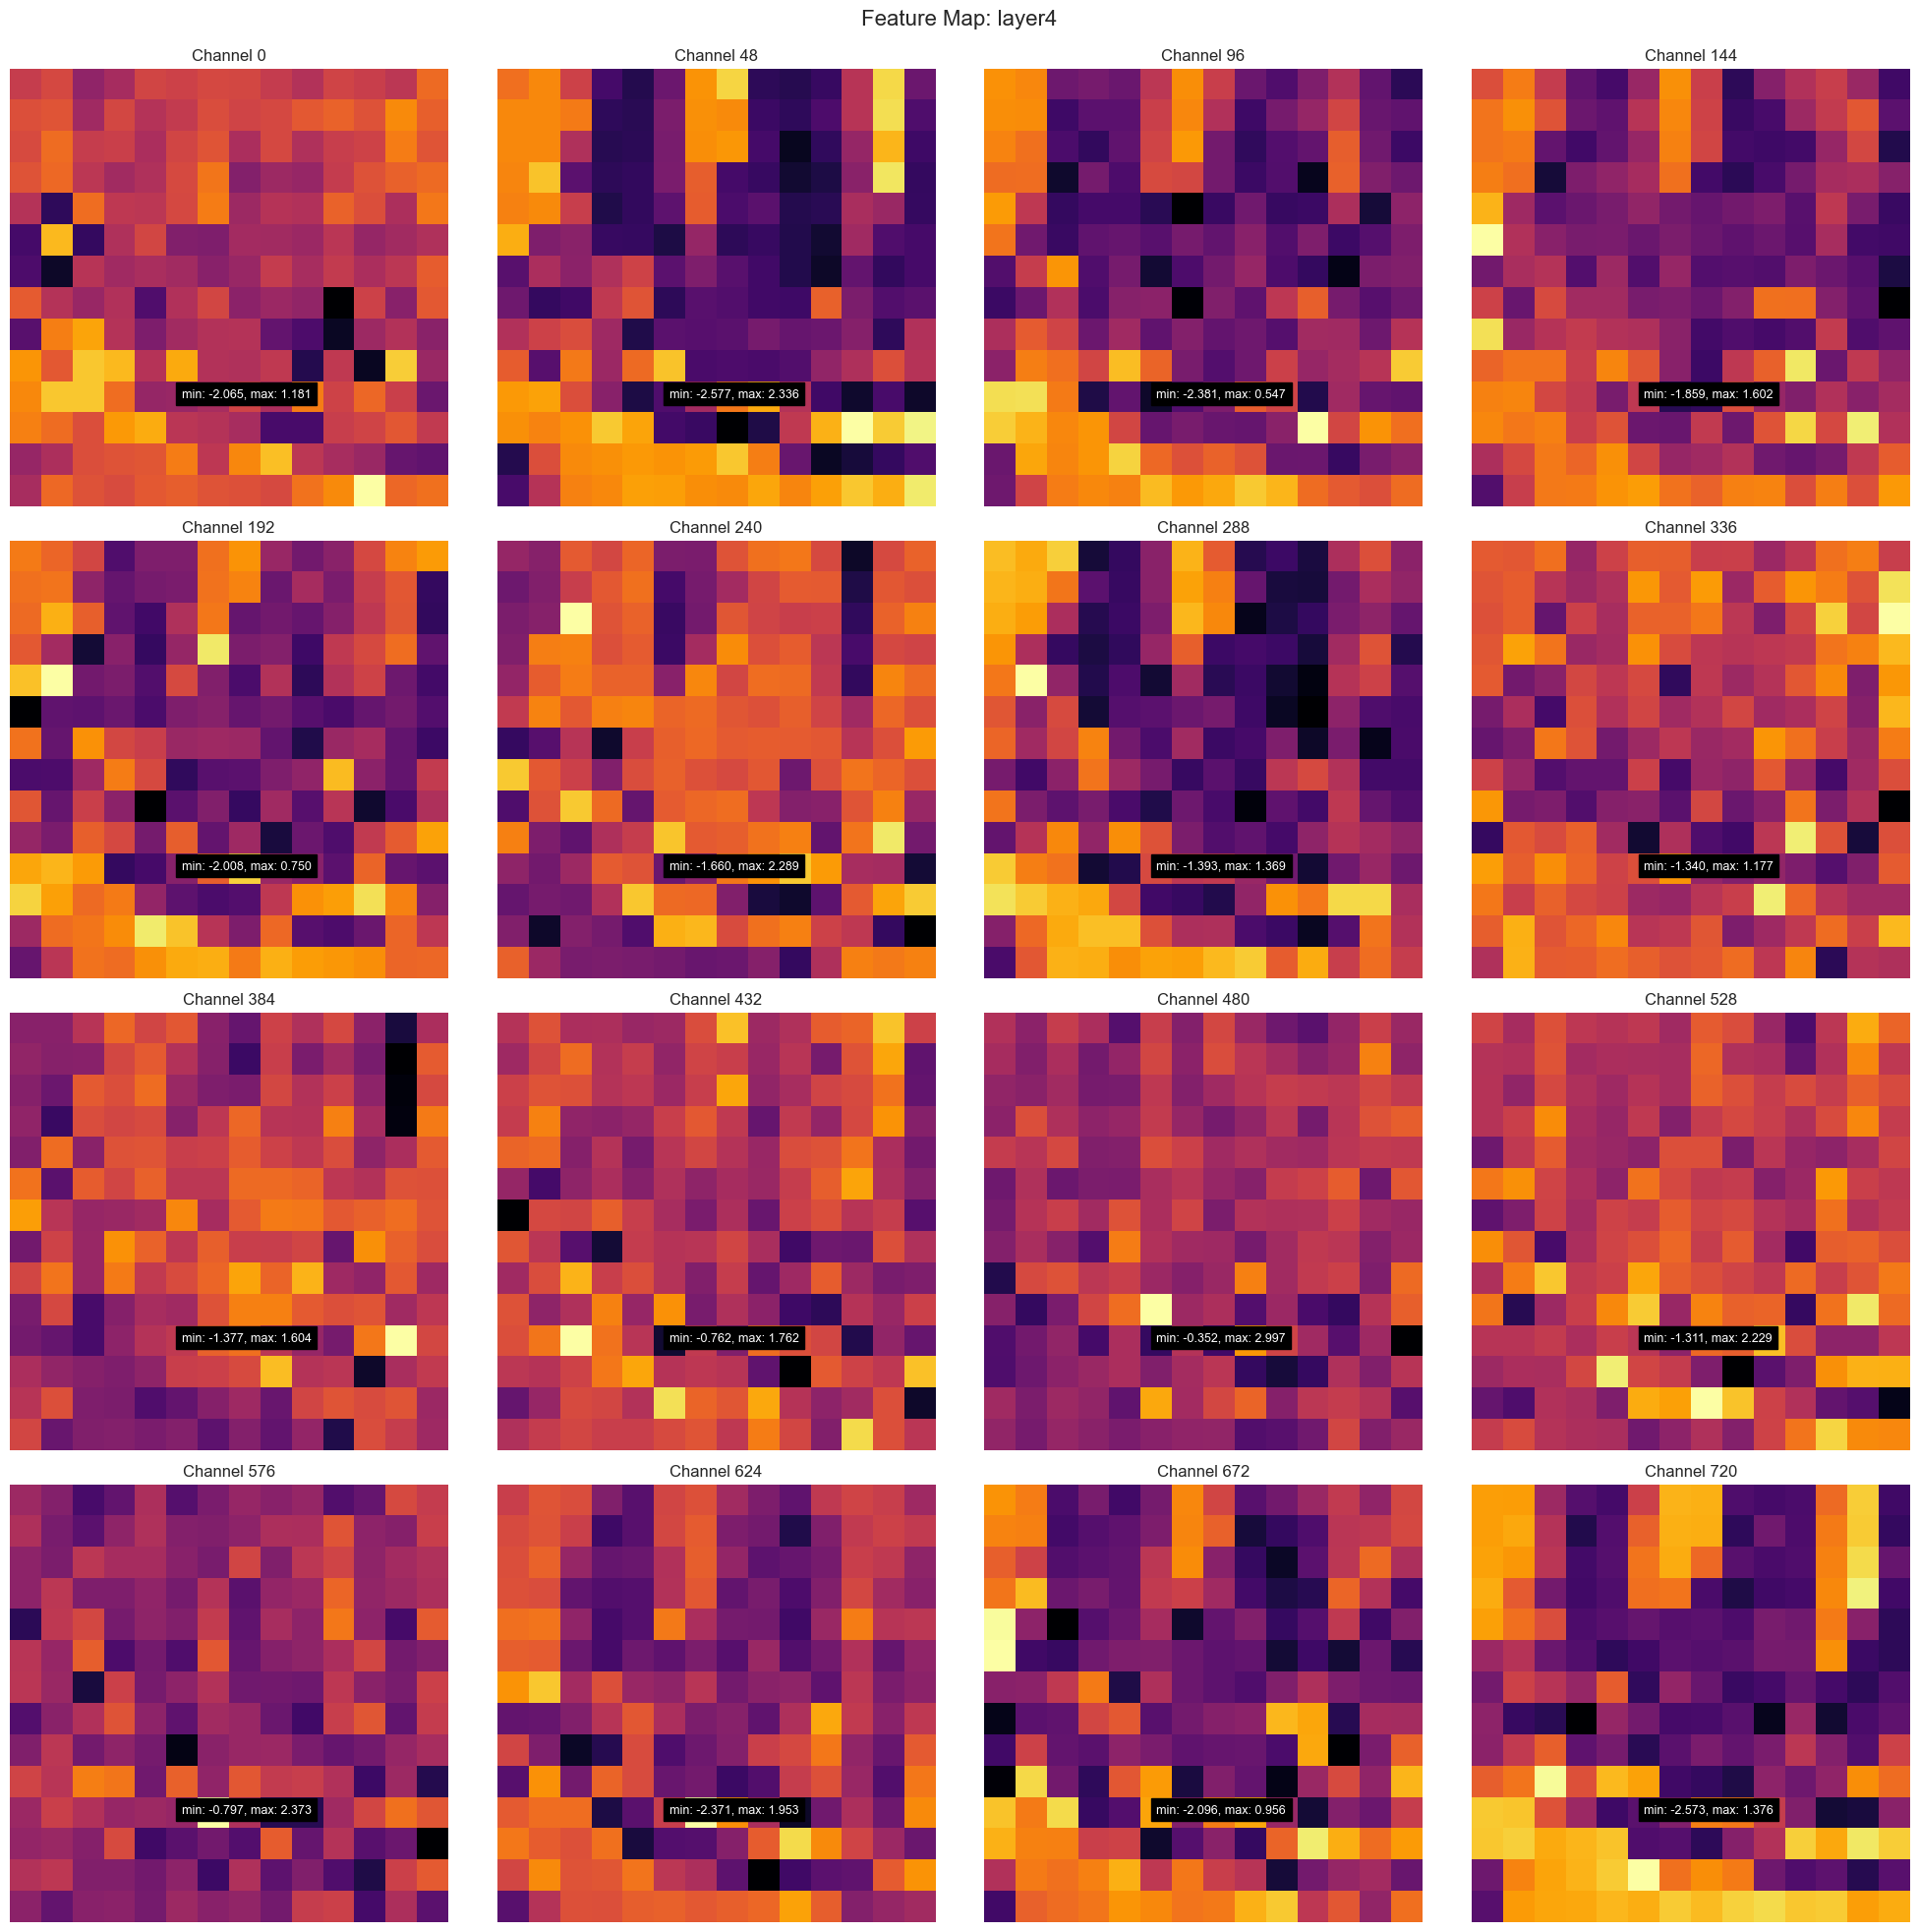

Skipping flat with shape torch.Size([1, 768]) - not a spatial feature map


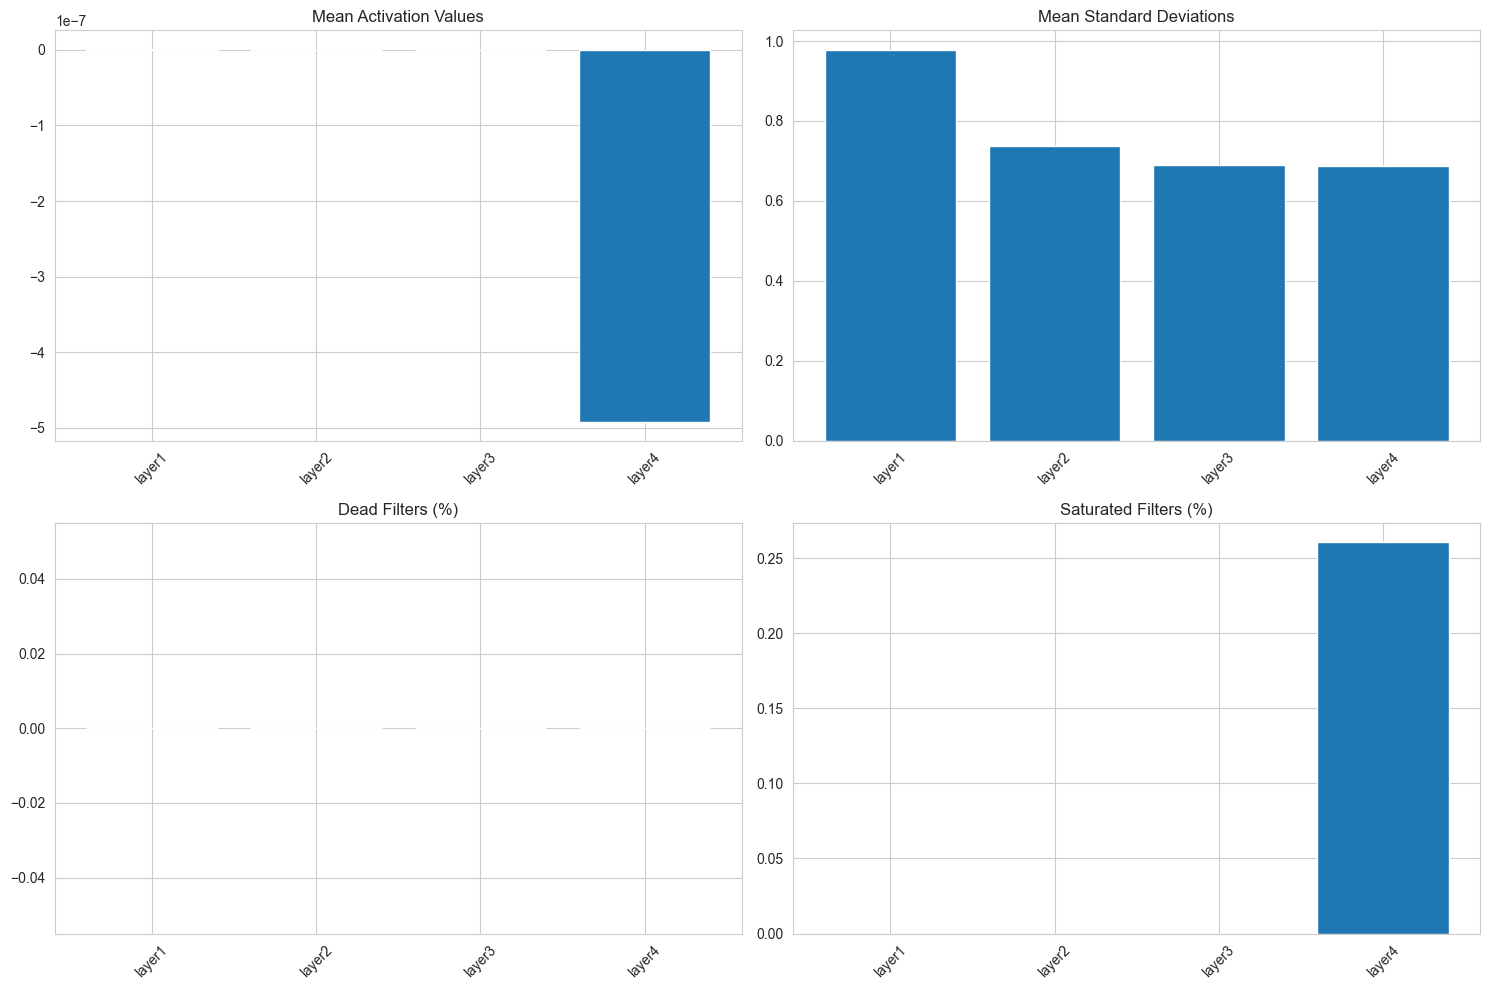


Detailed Feature Statistics:

layer1:
  Shape: torch.Size([1, 96, 112, 112])
  Mean: 0.0000
  Std Dev: 0.9778
  Min/Max: -2.1939/8.0717
  Dead Filters: 0 (0.00%)
  Saturated Filters: 0 (0.00%)

layer2:
  Shape: torch.Size([1, 192, 56, 56])
  Mean: 0.0000
  Std Dev: 0.7367
  Min/Max: -3.8901/3.8980
  Dead Filters: 0 (0.00%)
  Saturated Filters: 0 (0.00%)

layer3:
  Shape: torch.Size([1, 384, 28, 28])
  Mean: 0.0000
  Std Dev: 0.6910
  Min/Max: -4.1158/4.1658
  Dead Filters: 0 (0.00%)
  Saturated Filters: 0 (0.00%)

layer4:
  Shape: torch.Size([1, 768, 14, 14])
  Mean: -0.0000
  Std Dev: 0.6878
  Min/Max: -3.9173/4.0099
  Dead Filters: 0 (0.00%)
  Saturated Filters: 2 (0.26%)


In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from torchvision.utils import make_grid
import seaborn as sns
from pathlib import Path
import cv2

# Set up plotting
plt.rcParams['figure.figsize'] = (20, 15)
sns.set_style('whitegrid')

def load_image(image_path, size=(448, 448)):
    """Load and preprocess an image for the model"""
    img = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

def create_dummy_ms(rgb_tensor, num_channels=5):
    """Create a dummy multispectral image if you don't have real MS data"""
    # This is just for testing - replace with actual MS data loading if available
    batch_size, _, h, w = rgb_tensor.shape
    ms_tensor = torch.zeros((batch_size, num_channels, h, w), device=rgb_tensor.device)
    
    # Fill with some dummy data derived from RGB
    ms_tensor[:, 0] = rgb_tensor[:, 0]  # First channel similar to R
    ms_tensor[:, 1] = rgb_tensor[:, 1]  # Second channel similar to G
    ms_tensor[:, 2] = rgb_tensor[:, 2]  # Third channel similar to B
    ms_tensor[:, 3] = (rgb_tensor[:, 0] + rgb_tensor[:, 1]) / 2  # Fourth channel mix of R and G
    ms_tensor[:, 4] = (rgb_tensor[:, 1] + rgb_tensor[:, 2]) / 2  # Fifth channel mix of G and B
    
    return ms_tensor

def extract_features(model, rgb_tensor, ms_tensor=None):
    """Extract features from the backbone"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        if ms_tensor is None:
            ms_tensor = create_dummy_ms(rgb_tensor)
        
        # Extract features
        features = model.backbone(rgb=rgb_tensor, ms=ms_tensor)
    return features

def visualize_feature_maps(features, num_features_to_show=16, cmap='inferno'):
    """Visualize feature maps from the backbone"""
    for name, feature in features.items():
        # Skip non-spatial features
        if len(feature.shape) != 4:
            print(f"Skipping {name} with shape {feature.shape} - not a spatial feature map")
            continue
            
        print(f"\nFeature map: {name}, Shape: {feature.shape}")
        
        # Get the first image in the batch
        feature_map = feature[0]  # Shape: [C, H, W]
        
        # Determine how many feature maps to display
        num_channels = feature_map.shape[0]
        num_to_display = min(num_features_to_show, num_channels)
        
        # Select channels to display (evenly spaced)
        if num_channels <= num_to_display:
            channels_to_show = range(num_channels)
        else:
            step = num_channels // num_to_display
            channels_to_show = range(0, num_channels, step)[:num_to_display]
        
        # Create a grid of feature maps
        fig, axes = plt.subplots(4, 4, figsize=(20, 20))
        axes = axes.flatten()
        
        for i, channel_idx in enumerate(channels_to_show):
            if i >= len(axes):
                break
                
            # Get the feature map
            channel_data = feature_map[channel_idx].cpu().numpy()
            
            # Normalize for visualization
            channel_min, channel_max = channel_data.min(), channel_data.max()
            if channel_max > channel_min:
                channel_data = (channel_data - channel_min) / (channel_max - channel_min)
            
            # Display
            axes[i].imshow(channel_data, cmap=cmap)
            axes[i].set_title(f"Channel {channel_idx}")
            axes[i].axis('off')
            
            # Add some stats
            activation = feature_map[channel_idx]
            axes[i].text(5, 10, f"min: {activation.min():.3f}, max: {activation.max():.3f}",
                        color='white', fontsize=9, backgroundcolor='black')
            
        # Hide unused subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
            
        plt.suptitle(f"Feature Map: {name}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

def analyze_feature_statistics(features):
    """Analyze statistics of feature maps"""
    stats = {}
    
    for name, feature in features.items():
        if len(feature.shape) != 4:
            continue
            
        # Get feature statistics
        feat = feature[0]  # First image in batch
        channel_means = feat.mean(dim=(1, 2)).cpu().numpy()
        channel_stds = feat.std(dim=(1, 2)).cpu().numpy()
        channel_mins = feat.min(dim=1)[0].min(dim=1)[0].cpu().numpy()
        channel_maxs = feat.max(dim=1)[0].max(dim=1)[0].cpu().numpy()
        
        # Check for dead filters (all zeros or very low variance)
        dead_filters = (channel_stds < 1e-5).sum().item()
        dead_percentage = 100 * dead_filters / feat.shape[0]
        
        # Check for saturated filters (many activations close to max)
        saturated_filters = 0
        for c in range(feat.shape[0]):
            channel = feat[c]
            # Consider saturated if >10% of values are >0.9 of the max
            if channel.max() > 0:
                high_vals = (channel > 0.9 * channel.max()).float().mean().item()
                if high_vals > 0.1:  # >10% of values are high
                    saturated_filters += 1
        saturated_percentage = 100 * saturated_filters / feat.shape[0]
        
        stats[name] = {
            'shape': feature.shape,
            'mean': np.mean(channel_means),
            'std': np.mean(channel_stds),
            'min': np.min(channel_mins),
            'max': np.max(channel_maxs),
            'dead_filters': dead_filters,
            'dead_percentage': dead_percentage,
            'saturated_filters': saturated_filters,
            'saturated_percentage': saturated_percentage
        }
    
    # Plot statistics
    feature_names = list(stats.keys())
    means = [stats[name]['mean'] for name in feature_names]
    stds = [stats[name]['std'] for name in feature_names]
    dead_pcts = [stats[name]['dead_percentage'] for name in feature_names]
    saturated_pcts = [stats[name]['saturated_percentage'] for name in feature_names]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mean values
    axes[0, 0].bar(feature_names, means)
    axes[0, 0].set_title('Mean Activation Values')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Standard deviations
    axes[0, 1].bar(feature_names, stds)
    axes[0, 1].set_title('Mean Standard Deviations')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Dead filters
    axes[1, 0].bar(feature_names, dead_pcts)
    axes[1, 0].set_title('Dead Filters (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Saturated filters
    axes[1, 1].bar(feature_names, saturated_pcts)
    axes[1, 1].set_title('Saturated Filters (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    print("\nDetailed Feature Statistics:")
    for name, s in stats.items():
        print(f"\n{name}:")
        print(f"  Shape: {s['shape']}")
        print(f"  Mean: {s['mean']:.4f}")
        print(f"  Std Dev: {s['std']:.4f}")
        print(f"  Min/Max: {s['min']:.4f}/{s['max']:.4f}")
        print(f"  Dead Filters: {s['dead_filters']} ({s['dead_percentage']:.2f}%)")
        print(f"  Saturated Filters: {s['saturated_filters']} ({s['saturated_percentage']:.2f}%)")
    
    return stats

def visualize_feature_activations(image, features, layer_name, rgb_tensor):
    """Visualize what parts of the image activate certain feature maps"""
    if layer_name not in features:
        print(f"Layer {layer_name} not found in features")
        return
        
    feature_map = features[layer_name][0]  # First image in batch
    num_channels = feature_map.shape[0]
    
    # Select 9 random channels to visualize
    num_to_show = min(9, num_channels)
    channel_indices = np.random.choice(num_channels, num_to_show, replace=False)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    # Convert normalized tensor to displayable image
    rgb_img = rgb_tensor[0].cpu().permute(1, 2, 0).numpy()
    rgb_img = (rgb_img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    rgb_img = np.clip(rgb_img, 0, 1)
    
    for i, channel_idx in enumerate(channel_indices):
        if i >= len(axes):
            break
            
        # Get feature map for this channel
        activation = feature_map[channel_idx].cpu().numpy()
        
        # Normalize activation
        activation_min, activation_max = activation.min(), activation.max()
        if activation_max > activation_min:
            activation_norm = (activation - activation_min) / (activation_max - activation_min)
        else:
            activation_norm = activation
        
        # Resize activation to match image size
        activation_resized = cv2.resize(activation_norm, (rgb_img.shape[1], rgb_img.shape[0]))
        
        # Create a heatmap overlay
        heatmap = cv2.applyColorMap((activation_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        
        # Blend the original image with the heatmap
        alpha = 0.5
        blended = (1 - alpha) * rgb_img + alpha * heatmap
        
        # Display
        axes[i].imshow(blended)
        axes[i].set_title(f"Channel {channel_idx}")
        axes[i].axis('off')
        
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.suptitle(f"Feature Activations for Layer: {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

def compare_features_across_model(model, rgb_tensor, ms_tensor=None):
    """Compare feature maps at different stages of the model"""
    if ms_tensor is None:
        ms_tensor = create_dummy_ms(rgb_tensor)
    
    with torch.no_grad():
        # Get backbone features
        backbone_features = extract_features(model, rgb_tensor, ms_tensor)
        
        # Apply FPN to get FPN features
        fpn_features = model.fpn(backbone_features)
        
        # Compare feature statistics
        print("\n=== Backbone Features ===")
        backbone_stats = analyze_feature_statistics(backbone_features)
        
        print("\n=== FPN Features ===")
        fpn_stats = analyze_feature_statistics(fpn_features)
        
        # Compare activation patterns
        backbone_layer = list(backbone_features.keys())[1]  # Choose a middle layer
        fpn_layer = list(fpn_features.keys())[0]  # Choose first FPN layer
        
        print(f"\nComparing activation patterns between backbone layer {backbone_layer} and FPN layer {fpn_layer}")
        
        plt.figure(figsize=(12, 6))
        
        # First backbone feature channel
        plt.subplot(1, 2, 1)
        backbone_feat = backbone_features[backbone_layer][0][0].cpu().numpy()
        plt.imshow(backbone_feat, cmap='inferno')
        plt.title(f"Backbone: {backbone_layer}, Channel 0")
        plt.axis('off')
        
        # First FPN feature channel
        plt.subplot(1, 2, 2)
        fpn_feat = fpn_features[fpn_layer][0][0].cpu().numpy()
        plt.imshow(fpn_feat, cmap='inferno')
        plt.title(f"FPN: {fpn_layer}, Channel 0")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


features = pl_model.backbone(rgb=data["rgb"])
visualize_feature_maps(features, num_features_to_show=16)

# Analyze feature statistics
stats = analyze_feature_statistics(features)

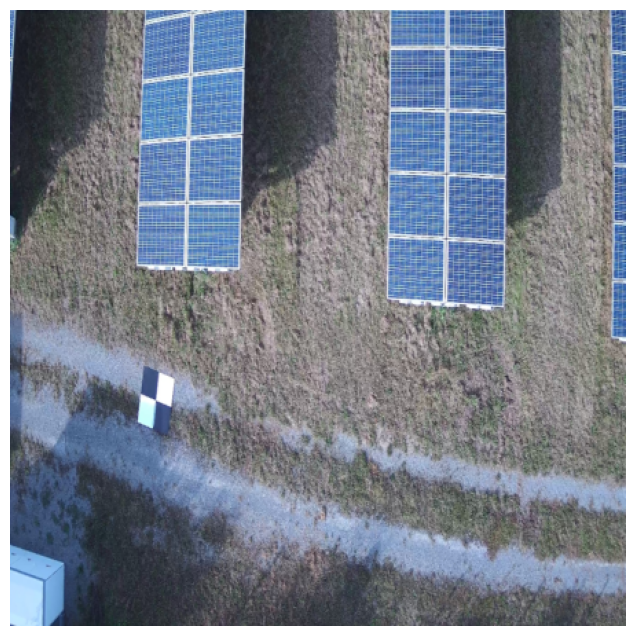

In [36]:

# Visualize the first image's results
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Get the first image and its detections
image = data['rgb'][0].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
boxes = results[0]['boxes'].cpu().numpy()
masks = results[0]['masks'].cpu().numpy()
scores = results[0]['scores'].cpu().numpy()
labels = results[0]['labels'].cpu().numpy()

# Plot image
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Plot boxes
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box
    rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(x1, y1, f"Class: {label}, {score:.2f}", color='white', backgroundcolor='red')

# Plot masks (overlay with transparency)
for mask in masks:
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
    colored_mask[mask > 0] = [1, 0, 0, 0.3]  # Red with 30% opacity
    plt.imshow(colored_mask)

plt.axis('off')
plt.show()